In [1]:
import math 
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%pip install graphviz


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [2]:
def f(x):
    return 3*x**2 + 5

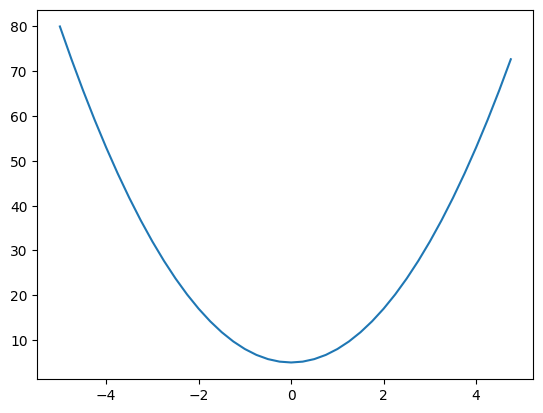

In [3]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [4]:
f(3.0)

32.0

In [5]:
h = 0.00001
x = 3
dx = (f(x + h) - f(x)) / h

In [6]:
dstep_length = .001
x = 3
x += -dx * dstep_length
f(x)

31.676971463242616

In [7]:
# minimize function value
def optimizer(func, step_len, x, num_steps):
    h = 0.00001
    for i in range(num_steps):
        dx = (func(x + h) - func(x)) / h
        print(x, dx, "func val:", func(x))
        x += -dx * step_len

In [8]:
h = 0.0001

#inputs 
a = 2.0
b = -3.0
c = 10.0 

d1 = a*b + c 
a += h 
d2 = a*b + c 

print("d1", d1)
print('d2', d2)
print('slope', (d2 - d1) / h)

dc = 1
db = 2
da = -3.0

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [9]:
class Value:

    def __init__(self, data,  _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda: None 

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self,other), '*')

        def _backward(): 
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __truediv__(self, other):
        out = Value(self.data / other.data, (self, other), '/')
        return out

    def __sub__(self, other):
        out = Value(self.data - other.data, (self, other), '-')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += -1.0 * out.grad
        out._backward = _backward

        return out    

    def tanh(self):
        x = self.data
        new_data = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(new_data, (self, ), 'tanh')

        def _backward(): 
            self.grad = (1 - (new_data)^2) * out.grad

        out._backward = _backward

        return out

        # 1 - tan^2(x)

    def __repr__(self):
        return f"Value(data={self.data})"


In [10]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a*b; e.label = 'e'

d = e + c; d.label = 'd'

f = Value(-2.0, label='f')

L = d * f; L.label = 'L'

print(L, L._prev)

'''
e = a * b
d = e + c 
L = d * f 
We would like to minimize L 
'''

Value(data=-8.0) {Value(data=4.0), Value(data=-2.0)}


'\ne = a * b\nd = e + c \nL = d * f \nWe would like to minimize L \n'

In [11]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

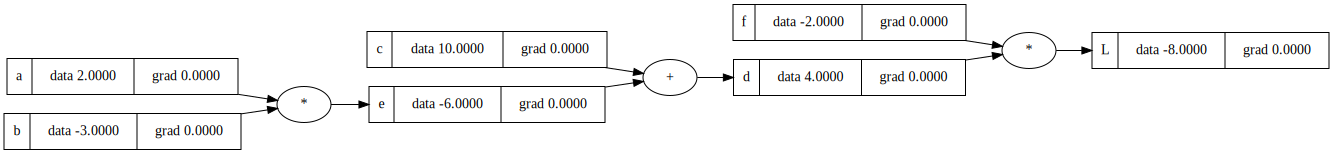

In [12]:
draw_dot(L)

In [13]:
h = .0000001
h = Value(h)

In [14]:
d.grad = ((f*(d + h) - (f*d))/ h).data
print(d.grad)

-2.0000000056086265


In [15]:
f.grad = (((f + h)*d - (f*d)) / h).data
print(f.grad)

4.000000002335469


In [16]:
e.grad = ((((e + h) + c) * f - ((e + c) * f)) / h).data
print(e.grad)

# L = (e + c) * f = ef + cf 

-2.0000000056086265


In [17]:
# L = d*f
# L = (e+c) * f
c.grad = (((e+(c+h))*f - (e+c)*f) / h).data
print(c.grad)

-1.999999987845058


In [18]:
# Now find a/b gradient only using a, b and e
# L = d * f
# L = (e + c) * f
# L = f*e + f*c

# dL/dA = dL/dE * dE/dA

a.grad = (Value(e.grad) * ((a+h) * b - a*b)/h).data
print(a.grad)

6.000000015888191


In [19]:
# HINT: CHAIN RULE
b.grad = (Value(e.grad) * ((b+h) * a - a*b)/h).data
print(b.grad)

-4.000000004670937


In [20]:
# WRITE A SINGLE PASS/STEP OF AN OPTIMIZER WHICH WILL CHANGE INPUTS TO MINIMIZE LOSS FUNCTION
print("original loss function value", L)
step_size = .1
step_size = Value(step_size)

a += (Value(-a.grad)* step_size)
b += (Value(-b.grad) * step_size)
c += (Value(-c.grad) * step_size)
e = a*b
d = e + c
f += (Value(-f.grad )* step_size)
L = d * f
print(L)
    

original loss function value Value(data=-8.0)
Value(data=-15.74400001009855)


In [25]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

# tanh(x1*w1 + x2*w2 + b)

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

In [ ]:
topological_sort = []
def dfs(node, visited):
   visited.add(node)
   for c in node._prev:
       if c not in visited:
           dfs(c, visited)
   topological_sort.append(node)


dfs(n, set())


topological_sort = topological_sort[::-1]


n.grad = 1.0
for c in topological_sort:
   if len(c._prev) > 0:
       print(c.label)
       c._backward()


In [23]:
# n.grad = 1.0
# n._backward()
# x1w1x2w2._backward()
# x2w2._backward()
# x1w1._backward()

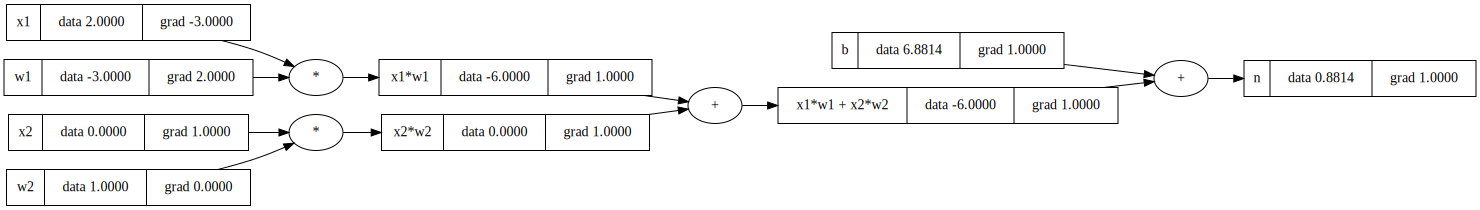

In [27]:
draw_dot(n)

In [ ]:
class Value:


   def __init__(self, data,  _children=(), _op='', label=''):
       self.data = data
       self.grad = 0.0
       self._prev = set(_children)
       self._op = _op
       self.label = label
       self._backward = lambda: None


   def __add__(self, other):
       out = Value(self.data + other.data, (self, other), '+')


       def _backward():
           self.grad += 1.0 * out.grad
           other.grad += 1.0 * out.grad
       out._backward = _backward


       return out
  
   def __mul__(self, other):
       out = Value(self.data * other.data, (self,other), '*')


       def _backward():
           self.grad += other.data * out.grad
           other.grad += self.data * out.grad


       out._backward = _backward
       return out


   def __truediv__(self, other):
       out = Value(self.data / other.data, (self, other), '/')
       return out


   def __sub__(self, other):
       out = Value(self.data - other.data, (self, other), '-')


       def _backward():
           self.grad += 1.0 * out.grad
           other.grad += -1.0 * out.grad
       out._backward = _backward


       return out   


   def tanh(self):
       x = self.data
       new_data = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
       out = Value(new_data, (self, ), 'tanh')


       def _backward():
           self.grad = (1 - (new_data)^2) * out.grad


       out._backward = _backward


       return out


       # 1 - tan^2(x)


   def __repr__(self):
       return f"Value(data={self.data})"

In [ ]:
import Random
class Node:
    def __init__(self):
        self.random = Random()
        a, b = 1, 100
        self.value = Value(self.random.randint(a, b))
        self.weights = {} #key will be connected node and value will be weight

        

In [ ]:
import Random
class Linear:
   def __init__(self, input_dim, output_dim):
       self.input_dim = input_dim
       self.output_dim = output_dim
       self.nodes = []
       a = 1
       b = 100
       for i in range(input_dim):
           self.nodes.append(Node())
          
class Compose:
    def __init__(self, layers):
        self.random = Random()
        self.layers = layers
        composed = Value(0.0)
        for i in range(len(self.layers)-1):
            layer_a = self.layers[i]
            layer_b = self.layers[i+1]
            if layer_a.output_dim != layer_b.input_dim:
                raise Exception("Dimensions dont match!!!")
            
            for node_b in layer_b:
                for node_a in layer_a:
                    if not node_a.weights[node_b]:
                        a,b = 1, 100
                        node_a.weights[node_b] = Value(self.random.randint(a, b))
                    node_b.value += (node_a.value*node_a.weights[node_b])
            
                   
                   
                   
                   



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=82e1abef-885a-4e94-bf15-6daa66930f1d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>